## Trabalho 1 -  MAE0326
TO-DO: 
* erro entre invariantes diminui ou converge?
* estimar Q

In [73]:
import numpy as np
from random import random, seed #uniforme

#geométrica normalizada que usamos em Q()
def normalized_geom(a, x, p):
    return (1 - p) ** (x-1) * p / (1 - (1-p) ** (a-1) * p)


In [74]:
#Simulação
#Ideias: escolher aleatoriamente ou deixar em 0, 1
def generate_simulation(n, p, state=None):
    if (state != None):
        seed(state)
    sim = np.zeros((n + 2), dtype="int32")
    sim[0] = 0
    sim[1] = 1
    i = 2
    while i < n + 2:
        #pega uma uniforme
        target = random()
    
        #Q(ba, x)
        if (sim[i - 1] != sim[i - 2]):
            if (target <= 1/2):
                sim[i] = sim[i - 1]
                continue
            acc = 1/2
            x = 0
            while (acc < target):
                x += 1
                if (x == sim[i - 1]):
                    continue
                acc += 0.5 * normalized_geom(sim[i - 1], x, p)
            sim[i] = x
        #Q(aa, x)
        else:
            acc = 0
            x = 0
            while (acc < target):
                x += 1
                if (x == sim[i - 1]):
                    continue
                acc += normalized_geom(sim[i - 1], x, p)
            sim[i] = x
        i += 1
    return sim[2:]
            
    

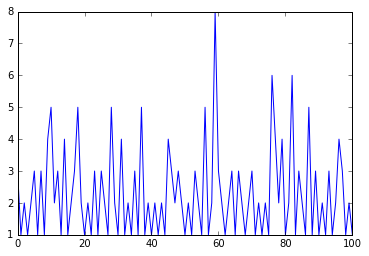

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(101), generate_simulation(101, 0.5, 0))
plt.show()

In [110]:
#estima medidas invariantes por contagem
def estimate_invariants(sim):
    return np.array([np.sum(sim == x) for x in range(max(sim))])[1:] / len(sim)

#calcula distancia entre invariantes, levando em conta que podem não ter o mesmo tamanho
def distance_invariants(pi_a, pi_b):
    minshape = min(pi_a.shape[0], pi_b.shape[0])
    dist = np.sum(np.abs(pi_a[:minshape] - pi_b[:minshape]))
    dist += np.sum(pi_a[minshape:]) + np.sum(pi_b[:minshape])
    return dist / max(pi_a.shape[0], pi_b.shape[0])

#estima invariantes do processo com p = p. Aumenta o tamanho da simulação até obter uma diferença menor que epsilon
def estimate_invariants_to_error(p, epsilon):
    delta = float('inf')
    #gera um estado aleatório para poder simular o mesmo processo a varios tamanhos
    state = random() 
    n = 1000
    base = generate_simulation(n, p, state)
    base_inv = estimate_invariants(base)
    while (delta > epsilon):
        prox = generate_simulation(n + 10, p, state)
        prox_inv = estimate_invariants(prox)
        
        delta = distance_invariants(base_inv, prox_inv)
        base = prox
        base_inv = prox_inv
        n = n + 1000
        if n == 1000000:
            break
        
    return base, base_inv, n, delta

In [ ]:
sim, pi, n, err = estimate_invariants_to_error(0.5, 0.01)

In [106]:
print(n, err)

1800 0.0913634547502
